In [1]:
from Pylice_def.shift_scheduling.preprocess import optimization_preprocess, create_min_demand
from Pylice_def.shift_scheduling.optimization import pylice_opt_model_hard
import pandas as pd 
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import time 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np 
demand = pd.read_csv("deamand_for_optimization.csv", index_col= "Unnamed: 0", dtype = {"Staffing Level" : int})
# From streamlit #limits/time = 300 limits/gap = 0.000001
earliest=  6
latest = 22
minimum_night = 3
minimum_day = 4
teamsize = 3
max_cap = 15
S_max =25 #?#
shift_lenghts = [6,7,8,9,10]
##################
ts_horizon, S,\
    demand, shift_costs,\
        t_s_cov, starting_shfits,\
            ending_shifts, possible_shifts,\
                shift_stats = optimization_preprocess(n_weeks = 1,
                                                    earliest_shift = earliest,
                                                    latest_shift = latest,
                                                    allowed_lens = shift_lenghts,
                                                    minimum_night= minimum_night,
                                                    minimum_day = minimum_day,
                                                    demand = demand)
time_t = ts_horizon
p_shifts = S
demand = demand
teamsize = teamsize
cap_max = max_cap
shift_cost = shift_costs
max_shifts = S_max
day_shift_match= t_s_cov
shift_day_match_start= starting_shfits
shift_day_match_end = ending_shifts

In [12]:
for key in demand:
    t_s_cov[key].append(demand[key])
    
for i in t_s_cov:
    print(t_s_cov.get(i)[-1])

In [2]:
# Creating Model instance
model = pyo.ConcreteModel()

##### Sets #####
model.setTime = pyo.Set(initialize = time_t) # time
model.setShifts = pyo.Set(initialize = p_shifts) # Possible Combination of Shifts
model.setDayShifts = pyo.Set(model.setTime, initialize = day_shift_match)
model.setEndingShifts = pyo.Set(model.setTime, initialize = shift_day_match_end)
model.setStartingShifts = pyo.Set(model.setTime, initialize = shift_day_match_start)
##### Parameters #####
model.E = pyo.Param(model.setTime, initialize = demand, within = pyo.Integers)
E = model.E

model.TS = pyo.Param(initialize = teamsize, within = pyo.Integers)
TS = model.TS

model.Cap_max = pyo.Param(initialize = cap_max, within = pyo.Integers)
Cap_max = model.Cap_max

model.C_Shift = pyo.Param(model.setShifts, initialize = shift_cost)
C_Shift = model.C_Shift

model.Max_Shift_Week = pyo.Param(initialize = max_shifts, within = pyo.Integers)
Max_S = model.Max_Shift_Week

##### Decision Variables #####
model.Allocated_Teams = pyo.Var(model.setShifts, within = pyo.Integers, bounds=(0.0, None))
x = model.Allocated_Teams

model.Tot_Costs = pyo.Var(within = pyo.Reals, bounds=(0.0, None))
z = model.Tot_Costs

model.ShiftSelect = pyo.Var(model.setShifts, within = pyo.Binary)
y = model.ShiftSelect

model.multiple = pyo.Var(model.setShifts, within = pyo.Integers, bounds=(0.0, None))
q = model.multiple

##### Objective Function #####

# First Objective Function

# model.obj_demand = pyo.Objective(expr = sum([(sum([x[s]*y[s]*Cov[t,s] for s in model.setDayShifts[t]]))-E[t] for t in model.setTime]), sense = pyo.minimize) #TS

# Second Objective Function
model.obj_costs = pyo.Objective(expr = z, sense = pyo.minimize)

##### s.t. #####

# Team Allocation
model.C1 = pyo.ConstraintList()
for s in model.setShifts:
    model.C1.add(expr = x[s] <= y[s]*Cap_max)

model.C2 = pyo.ConstraintList()
for s in model.setShifts:
    model.C2.add(expr = x[s] >= y[s])

# Make x a multiple of TS
model.C3 = pyo.ConstraintList()
for s in model.setShifts:
    model.C3.add(expr = x[s] == TS * q[s]) 

# Demand Coverage
model.C4 = pyo.ConstraintList()
for t in model.setTime:
    model.C4.add(expr = sum(x[s] for s in model.setDayShifts[t]) >= E[t])

# cover all periods in horizon with at least one shift xxxx
# model.C5 = pyo.ConstraintList()
# for t in model.setTime:
#     model.C5.add(expr = sum(y[s] for s in model.setDayShifts[t]) >= 1)

# Max Allocation
model.C6 = pyo.ConstraintList()
for t in model.setTime:
    model.C6.add(expr = sum(x[s] for s in model.setDayShifts[t]) <= Cap_max)

# Max Number of shifts in the week
model.C7 = pyo.Constraint(expr = sum(y[s] for s in model.setShifts) <= Max_S)

# Force Overlap on shift change
# model.C8 = pyo.ConstraintList()
# for t in model.setStartingShifts:
#     model.C8.add(expr = sum(y[s] for s in model.setEndingShifts[t]) == sum(y[s] for s in model.setStartingShifts[t]))

# Cost
model.C9 = pyo.Constraint(expr = z == sum(C_Shift[s]*x[s] for s in model.setShifts))# *TS


opt = SolverFactory('scipampl')

results = opt.solve(model, tee=True)


SCIP version 7.0.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.0] [GitHash: 0bc4dc9c65]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.0         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 6535a3c8]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  bliss 0.73p          Computing Graph Automorphism Groups by T. Junttila and P. Kaski (http://www.tcs.hut.fi/Software/bliss/)
  Ipopt 3.13.1         Interior Point Optimizer developed by A. Waechter et.al. (www.coin-or.org/Ipopt)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of parameters = 2608
non-default parameter settings:


read problem <C:\Users\joach\AppData\Local\Temp\tmpujgneq9n.pyomo.nl>

original problem has 1114 variables (371 bin, 742 int, 0 impl, 1 cont) and 1451 constraints

 

In [8]:
# Shift chosen + number of teams allocated to the shift 
### PS! Possible reason for lower cost than Karim: We are only multiplying number of teams, not for each person in team as well
choosen = []
for i in model.ShiftSelect:
    choosen.append((i,pyo.value(model.ShiftSelect[i]) , pyo.value(model.Allocated_Teams[i])))
choosen_with_emp = pd.DataFrame(choosen).rename(columns = {1 : "selected", 2 : "staff"})
choosen_with_emp = choosen_with_emp.loc[(choosen_with_emp["selected"] > 0) & (choosen_with_emp["staff"] > 0)].set_index(0, drop = True).drop(columns= "selected", axis = 1)

chosen_list = []
for index, row in choosen_with_emp.iterrows():
    temp = index, row.staff
    chosen_list.append(temp) 

# display(choosen)
display(chosen_list)

[('Shift-9', 3.0),
 ('Shift-22', 6.0),
 ('Shift-34', 6.0),
 ('Shift-61', 6.0),
 ('Shift-73', 6.0),
 ('Shift-118', 6.0),
 ('Shift-125', 3.0),
 ('Shift-129', 6.0),
 ('Shift-162', 6.0),
 ('Shift-170', 3.0),
 ('Shift-199', 3.0),
 ('Shift-209', 6.0),
 ('Shift-218', 3.0),
 ('Shift-228', 3.0),
 ('Shift-241', 3.0),
 ('Shift-242', 6.0),
 ('Shift-252', 6.0),
 ('Shift-288', 3.0),
 ('Shift-298', 3.0),
 ('Shift-320', 3.0),
 ('Shift-330', 3.0),
 ('Shift-340', 3.0),
 ('Shift-350', 3.0),
 ('Shift-360', 3.0),
 ('Shift-370', 3.0)]

In [52]:
# Shift chosen + cost of each shift
chosen_shifts = []
for i in chosen_list:
    chosen_shifts.append(i[0])

chosen_shift_cost = []
for i in shift_cost:
    if i in chosen_shifts:
        temp = i, shift_cost.get(i)
        chosen_shift_cost.append(temp)

In [6]:
from Pylice_def.shift_scheduling import page
results, n_assigned = page.tabularize_results(model, shift_stats, ts_horizon, possible_shifts)
n_assigned.sort_index(inplace = True)
demand = pd.DataFrame.from_dict({"Demand":demand}).sort_index()
n_assigned["Demand"] = demand["Demand"]
n_assigned["OverStaffing"] = n_assigned["Assigned"] - n_assigned["Demand"]
n_assigned


,Assigned,Demand,OverStaffing
Friday 00:00:00,3.0,3.0,0.0
Friday 01:00:00,3.0,3.0,0.0
Friday 02:00:00,3.0,3.0,0.0
Friday 03:00:00,3.0,3.0,0.0
Friday 04:00:00,3.0,3.0,0.0
...,...,...,...
Wednesday 19:00:00,6.0,4.0,2.0
Wednesday 20:00:00,6.0,3.0,3.0
Wednesday 21:00:00,3.0,3.0,0.0
Wednesday 22:00:00,3.0,3.0,0.0


In [7]:
results

,Shift_name,staff,start_num,end_num,start-end,len,color
14,Shift-241,3.0,22,31,22:00:00 - 07:00:00,9,#E69646
23,Shift-360,3.0,141,151,21:00:00 - 07:00:00,10,#E69646
22,Shift-350,3.0,117,127,21:00:00 - 07:00:00,10,#E69646
21,Shift-340,3.0,93,103,21:00:00 - 07:00:00,10,#E69646
20,Shift-330,3.0,69,79,21:00:00 - 07:00:00,10,#E69646
19,Shift-320,3.0,45,55,21:00:00 - 07:00:00,10,#E69646
24,Shift-370-->,3.0,165,0,21:00:00 - 00:00:00,3,#E69646
2,Shift-34,6.0,63,69,15:00:00 - 21:00:00,6,#E64646
1,Shift-22,6.0,39,45,15:00:00 - 21:00:00,6,#E64646
9,Shift-170,3.0,14,22,14:00:00 - 22:00:00,8,#E64646


2023-03-18 18:44:55.054 
  command:

    streamlit run c:\Users\joach\Anaconda3\envs\thesis_venv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


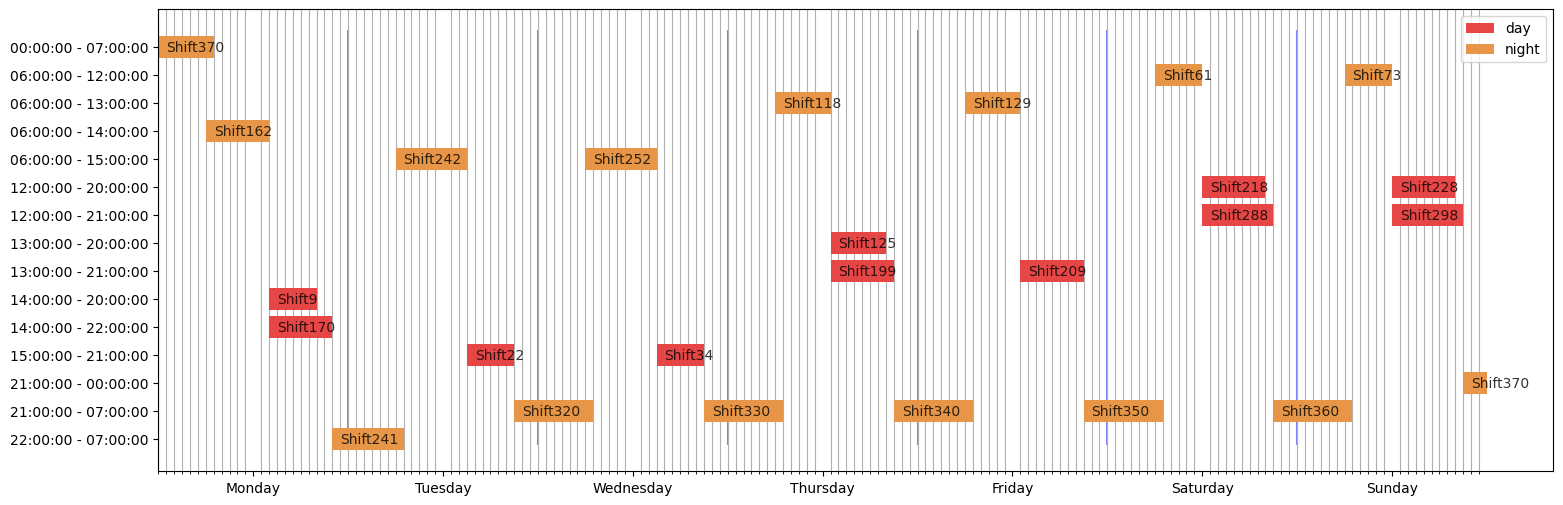

In [57]:
from Pylice_def.shift_scheduling import page
results, n_assigned = page.tabularize_results(model, shift_stats, ts_horizon, possible_shifts)
schedule_graph = page.plot_resulting_schedule(results)
plt.show()

In [58]:
n_assigned.sort_index(inplace = True)
demand = pd.DataFrame.from_dict({"Demand":demand}).sort_index()
n_assigned["Demand"] = demand["Demand"]
n_assigned["OverStaffing"] = n_assigned["Assigned"] - n_assigned["Demand"]
print(n_assigned.OverStaffing.mean())
print(n_assigned.OverStaffing.max())
pyo.value(model.Tot_Costs)

1.3452380952380953
5.0


338080.5

In [15]:
results

,Shift_name,staff,start_num,end_num,start-end,len,color
39,Shift-361,3.552714e-15,142,152,22:00:00 - 08:00:00,10,#E69646
43,Shift-371-->,2.220446e-15,166,0,22:00:00 - 00:00:00,2,#E69646
38,Shift-360,3.000000e+00,141,151,21:00:00 - 07:00:00,10,#E69646
35,Shift-330,3.000000e+00,69,79,21:00:00 - 07:00:00,10,#E69646
33,Shift-310,3.000000e+00,21,31,21:00:00 - 07:00:00,10,#E69646
34,Shift-320,3.000000e+00,45,55,21:00:00 - 07:00:00,10,#E69646
37,Shift-350,3.000000e+00,117,127,21:00:00 - 07:00:00,10,#E69646
36,Shift-340,3.000000e+00,93,103,21:00:00 - 07:00:00,10,#E69646
41,Shift-370-->,3.000000e+00,165,0,21:00:00 - 00:00:00,3,#E69646
6,Shift-71,3.552714e-15,136,142,16:00:00 - 22:00:00,6,#E64646


In [16]:
import datetime
def adding_overlap_start_end(x: pd.Series):
    start = x.split()[0]
    end = x.split()[2]
    if end == '00:00:00':
        end_updated = end 
    else:
        end_time_object = datetime.datetime.strptime(end, '%H:%M:%S')
        end_updated = end_time_object + datetime.timedelta(minutes=15)
        end_updated = str(end_updated.time())
        
    start_time_object = datetime.datetime.strptime(start, '%H:%M:%S')
    start_updated = start_time_object + datetime.timedelta(hours=-1, minutes=45)
    start_updated = str(start_updated.time())
        
    updated_shift_time = str(' - '.join([start_updated, end_updated]))
    return updated_shift_time

In [17]:
def adding_overlap_end(x: pd.Series):
    start = x.split()[0]
    end = x.split()[2]
    if end == '00:00:00':
        end_updated = end 
    else:
        end_time_object = datetime.datetime.strptime(end, '%H:%M:%S')
        end_updated = end_time_object + datetime.timedelta(minutes=15)
        end_updated = str(end_updated.time())
        
    updated_shift_time = str(' - '.join([start, end_updated]))
    return updated_shift_time

In [18]:
## Ending shifts need always 15 minutes extra, starting shifts only when another shift ends at that time
starts = {}
ends = {}
for index, row in results.iterrows():
    start_key = row['Shift_name']
    start_value = row['start_num']
    end_key = row['Shift_name']
    end_value = row['end_num']
    starts[start_key] = start_value
    ends[end_key] = end_value
add_time_start_shifts = []
for s_key in starts:
    s_value = starts.get(s_key)
    if s_value in ends.values():
        add_time_start_shifts.append(s_key)
add_time_start_shifts        

['Shift-361',
 'Shift-360',
 'Shift-330',
 'Shift-310',
 'Shift-320',
 'Shift-350',
 'Shift-340',
 'Shift-370-->',
 'Shift-71',
 'Shift-34',
 'Shift-70',
 'Shift-82',
 'Shift-159',
 'Shift-137',
 'Shift-93',
 'Shift-199',
 'Shift-219',
 'Shift-248',
 'Shift-218',
 'Shift-224',
 'Shift-153',
 'Shift-75',
 'Shift-3',
 'Shift-363',
 'Shift-283',
 'Shift-213',
 'Shift-223',
 'Shift-183',
 'Shift-130',
 '-->Shift-371',
 '-->Shift-370']

In [19]:
results['start-end'] = results['start-end'].apply(lambda x: adding_overlap_start_end(x) if results.loc[results['start-end'] == x, 'Shift_name'].iloc[0] in add_time_start_shifts else adding_overlap_end(x))

In [20]:
results # now problem with the max length of shift only 

,Shift_name,staff,start_num,end_num,start-end,len,color
39,Shift-361,3.552714e-15,142,152,21:45:00 - 08:15:00,10,#E69646
43,Shift-371-->,2.220446e-15,166,0,22:00:00 - 00:00:00,2,#E69646
38,Shift-360,3.000000e+00,141,151,20:45:00 - 07:15:00,10,#E69646
35,Shift-330,3.000000e+00,69,79,20:45:00 - 07:15:00,10,#E69646
33,Shift-310,3.000000e+00,21,31,20:45:00 - 07:15:00,10,#E69646
34,Shift-320,3.000000e+00,45,55,20:45:00 - 07:15:00,10,#E69646
37,Shift-350,3.000000e+00,117,127,20:45:00 - 07:15:00,10,#E69646
36,Shift-340,3.000000e+00,93,103,20:45:00 - 07:15:00,10,#E69646
41,Shift-370-->,3.000000e+00,165,0,20:45:00 - 00:00:00,3,#E69646
6,Shift-71,3.552714e-15,136,142,15:45:00 - 22:15:00,6,#E64646


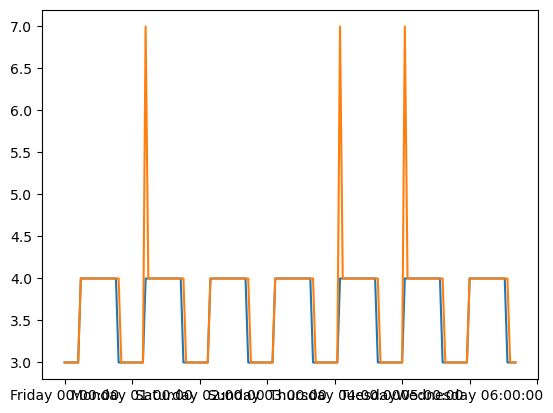

In [5]:
n_assigned["Demand"].plot()
n_assigned["Assigned"].plot()
plt.show()